# 1 - Config

## 1.1 - Launch Spark session

In [1]:
# run this cell as is to launch Spark session

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1724521548836_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
# get info on running Spark session
# %%info

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# create entry point for Spark functionality (cluster connection)
# see https://spark.apache.org/docs/1.6.1/api/java/org/apache/spark/SparkContext.html
sc = spark.sparkContext

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 1.2 - Check installs & import packages

In [4]:
# list all the packages installed in the spark session to confirm correct execution of cluster bootstrap
sc.list_packages() 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                      Version
---------------------------- ------------
absl-py                      2.1.0
aiobotocore                  2.13.3
aiohappyeyeballs             2.4.0
aiohttp                      3.10.5
aioitertools                 0.11.0
aiosignal                    1.3.1
appdirs                      1.4.4
astunparse                   1.6.3
async-timeout                4.0.3
attrs                        20.3.0
aws-cfn-bootstrap            2.0
aws-hadoop                   1.0.dev2
awscli                       2.15.30
awscrt                       0.19.19
Babel                        2.9.1
bcrypt                       4.2.0
beautifulsoup4               4.9.3
boto                         2.49.0
botocore                     1.34.162
cffi                         1.14.5
chardet                      4.0.0
chevron                      0.13.1
click                        8.1.7
cloud-init                   22.2.2
colorama                     0.4.4
configobj                    5

**pandas 2.2.2, tensorflow 2.17.0, pillow 10.4.0, pyarrow 17.0.0, aws-hadoop 1.0.dev2, fsspec 2024.6.1, s3fs 2024.6.1 and matplotlib 3.5.2 installed as per bootstrap**

In [5]:
# import libraries and functions

import pandas as pd
from PIL import Image
import numpy as np
import io
import os
import sys
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession
import s3fs
import fsspec
import matplotlib.pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 1.3 - Define paths for images download & results upload

In [6]:
PATH = 's3://ocds-p9-data'
PATH_Data = PATH+'/Test1'
PATH_Results = PATH+'/Results_Cloud'
PATH_PCA = PATH+'/PCA_Results_Cloud'
PATH_PCA_CSV = PATH+'/PCA_Results_Cloud_csv'
print('PATH:        '+\
      PATH
      +'\nPATH_Data:   '+\
      PATH_Data
      +'\nPATH_Results: '+\
      PATH_Results
      +'\nPATH_PCA: '+\
      PATH_PCA
      +'\nPATH_PCA_CSV: '+\
      PATH_PCA_CSV)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://ocds-p9-data
PATH_Data:   s3://ocds-p9-data/Test1
PATH_Results: s3://ocds-p9-data/Results_Cloud
PATH_PCA: s3://ocds-p9-data/PCA_Results_Cloud
PATH_PCA_CSV: s3://ocds-p9-data/PCA_Results_Cloud_csv

# 2 - MobileNetV2 transfer learning

## 2.1 - Load images

In [7]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+----------------------------------------+-----+
|path                                    |label|
+----------------------------------------+-----+
|s3://ocds-p9-data/Test1/lime/113_100.jpg|lime |
|s3://ocds-p9-data/Test1/lime/114_100.jpg|lime |
|s3://ocds-p9-data/Test1/lime/121_100.jpg|lime |
|s3://ocds-p9-data/Test1/lime/120_100.jpg|lime |
|s3://ocds-p9-data/Test1/lime/118_100.jpg|lime |
+----------------------------------------+-----+
only showing top 5 rows

None

## 2.2 - Instanciate model

In [9]:
model = MobileNetV2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
new_model = Model(inputs=model.input, outputs=model.layers[-2].output)
new_model.summary()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Model: "functional"
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Con

## 2.3 - Broadcast weights

In [10]:
from pyspark.sql.functions import broadcast
broadcast_weights = sc.broadcast(new_model.get_weights())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 2.4 - Define transfer learning functions

In [11]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(broadcast_weights.value)
    return new_model

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction. When you load an image with imread(), the pixel values are in the 0 - 255
    range. However, MobileNetV2 expects pixel values to be in the -1 to 1 range. You could perform this transformation yourself,
    but Keras also provides preprocessing functions - use from keras.applications.mobilenet_v2 import preprocess_input
    source : https://pythontutorials.eu/deep-learning/image-classification/
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    
    # make sure verbose is set to FALSE in model.predict otherwise
    # features_df.write.option("encoding", "utf-8").mode("overwrite").parquet(PATH_Results)
    # will raise a WIN1252 codec writing error when writing the parquet file at OUT[28] below
    preds = model.predict(input, verbose=0)
    
       
    
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1724521548836_0001/container_1724521548836_0001_01_000001/pyspark.zip/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

## 2.5 - Apply model to fruit images sample

In [14]:
# Apply model transfer learning to images
features_df = images.repartition(20).select(col("path"), col("label"), featurize_udf("content").alias("features"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
# write results to s3 bucket

# make sure verbose is set to FALSE in model.predict at IN[24] above otherwise the following error will be raised
# caused by org.apache.spark.sparkexception task failed while writing rows Anaconda3\lib\encodings\cp1252.py 'charmap' codec
# can't encode characters in position 19-38: character maps to <undefined>
features_df.write.option("encoding", "utf-8").mode("overwrite").parquet(PATH_Results)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
# check results
df = pd.read_parquet(PATH_Results, engine='pyarrow')
df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                               path  ...                                           features
0  s3://ocds-p9-data/Test1/passionfruit/109_100.jpg  ...  [0.25161672, 0.0, 0.0, 0.0, 0.0083105415, 0.76...
1         s3://ocds-p9-data/Test1/salak/133_100.jpg  ...  [2.4172416, 0.0652101, 0.0, 0.0063302275, 0.0,...
2  s3://ocds-p9-data/Test1/passionfruit/110_100.jpg  ...  [0.32722062, 0.0, 0.0, 0.0, 0.0, 0.7796022, 0....
3      s3://ocds-p9-data/Test1/salak/10_100 (1).jpg  ...  [1.9246143, 0.06737837, 0.0, 0.0056824684, 0.0...
4         s3://ocds-p9-data/Test1/salak/132_100.jpg  ...  [2.3859947, 0.07431848, 0.0, 0.001740767, 0.0,...

[5 rows x 3 columns]

In [17]:
# check features vectors have expected size
df.loc[0,'features'].shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(1280,)

# 3 - PCA on model results

## 3.1 - Import packages & prepare model data

In [18]:
# import packages and functions required
from pyspark.ml.feature import PCA
from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.feature import StandardScaler

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
# check data type of resulting dataframe vector column
df['features'].values.dtype

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

dtype('O')

In [20]:
# transform df['features'] vectors column into dataframe
# vstack rebuilds arrays divided by vsplit - see numpy doc at https://numpy.org/doc/stable/reference/generated/numpy.vstack.html
df2 = pd.DataFrame(np.vstack(df['features']))
df2.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       0         1     2         3     ...      1276  1277      1278      1279
0  0.251617  0.000000   0.0  0.000000  ...  0.000000   0.0  0.057831  0.001474
1  2.417242  0.065210   0.0  0.006330  ...  0.004630   0.0  0.081895  0.049530
2  0.327221  0.000000   0.0  0.000000  ...  0.000000   0.0  0.053580  0.020879
3  1.924614  0.067378   0.0  0.005682  ...  0.013763   0.0  0.000000  1.446880
4  2.385995  0.074318   0.0  0.001741  ...  0.000000   0.0  0.120571  0.347208

[5 rows x 1280 columns]

In [21]:
# careful - it is the Spark session (called 'spark' in this notebook) that has a createDataFrame attribute,
# not the Sark Context sc - see https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.SparkSession.createDataFrame.html
# and https://stackoverflow.com/questions/40651003/attributeerror-sparkcontext-object-has-no-attribute-createdataframe-using-s
# so this test_sdf = sc.createDataFrame(df2) triggers error
# test_sdf = spark.createDataFrame(df2) # but this works just fine

# convert pandas df to Spark df
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
spark_df2 = sqlContext.createDataFrame(df2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1724521548836_0001/container_1724521548836_0001_01_000001/pyspark.zip/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.

In [22]:
cols = df2.columns.astype(str).tolist()

# instanciate vector assembler 
assembler = VectorAssembler(inputCols=cols, outputCol="features")

# transform df
prepared_df = assembler.transform(spark_df2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 3.2 - Run PCA

In [23]:
# instanciate PCA with all the possible components
pca = PCA(k= len(cols), inputCol="features")
pca.setOutputCol("pca_features")

# fit PCA to transformed df
pca_model = pca.fit(prepared_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
# pca_model.explainedVariance

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
sum(pca_model.explainedVariance)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.9999999999999999

In [26]:
# print principal components matrix, where each column is one principal component.
# cf. https://github.com/haipinglu/ScalableML/blob/master/Lab%207%20-%20Scalable%20PCA%20for%20dimensionality%20reduction%20and%20Spark%20data%20types.md
print(pca_model.pc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DenseMatrix([[-9.31079704e-02,  2.09250347e-03,  9.55949641e-03, ...,
               9.84207887e-03, -7.33043030e-03, -3.69444644e-03],
             [ 7.04155948e-03, -1.67418068e-02,  2.17070044e-02, ...,
              -2.60630432e-03, -1.05679955e-02, -2.02469810e-03],
             [ 6.58751450e-03, -3.87996799e-03, -1.35025139e-02, ...,
              -5.02816192e-03,  1.91854685e-02,  7.32883571e-03],
             ...,
             [ 9.17668785e-03,  2.39952683e-02, -1.11231195e-03, ...,
               7.97071920e-03, -1.35078877e-02,  2.09561338e-02],
             [ 4.15803773e-05, -3.55021706e-03,  3.58232582e-03, ...,
              -3.29646972e-03, -1.29269447e-03,  4.78576278e-03],
             [-2.63720768e-02, -8.91145260e-04, -2.53345698e-03, ...,
               1.99972755e-02, -1.89528895e-02, -2.15414777e-02]])

In [27]:
# explained variance of the PCs
df_var = pd.DataFrame(pca_model.explainedVariance, columns=['explained_var'])
df_var.insert(0, 'component', value= ['PC'+str(n) for n in range(1,len(cols)+1)])
df_var['cum_var'] = df_var['explained_var'].cumsum()
df_var

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     component  explained_var   cum_var
0          PC1   2.085289e-01  0.208529
1          PC2   1.947873e-01  0.403316
2          PC3   1.761070e-01  0.579423
3          PC4   1.145331e-01  0.693956
4          PC5   7.690839e-02  0.770865
...        ...            ...       ...
1275    PC1276   2.232886e-17  1.000000
1276    PC1277   1.617141e-17  1.000000
1277    PC1278   1.329430e-17  1.000000
1278    PC1279   7.956548e-18  1.000000
1279    PC1280   3.380305e-18  1.000000

[1280 rows x 3 columns]

In [28]:
var_tot = df_var['explained_var'].sum()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
cutoff = var_tot/1280
print("Minimum contribution of components:", round(cutoff,6))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Minimum contribution of components: 0.000781

In [30]:
df_var_trim = df_var.loc[df_var['explained_var'] > cutoff]
print("Number of components meeting minimum contribution criterion:", df_var_trim.shape[0])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of components meeting minimum contribution criterion: 36

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

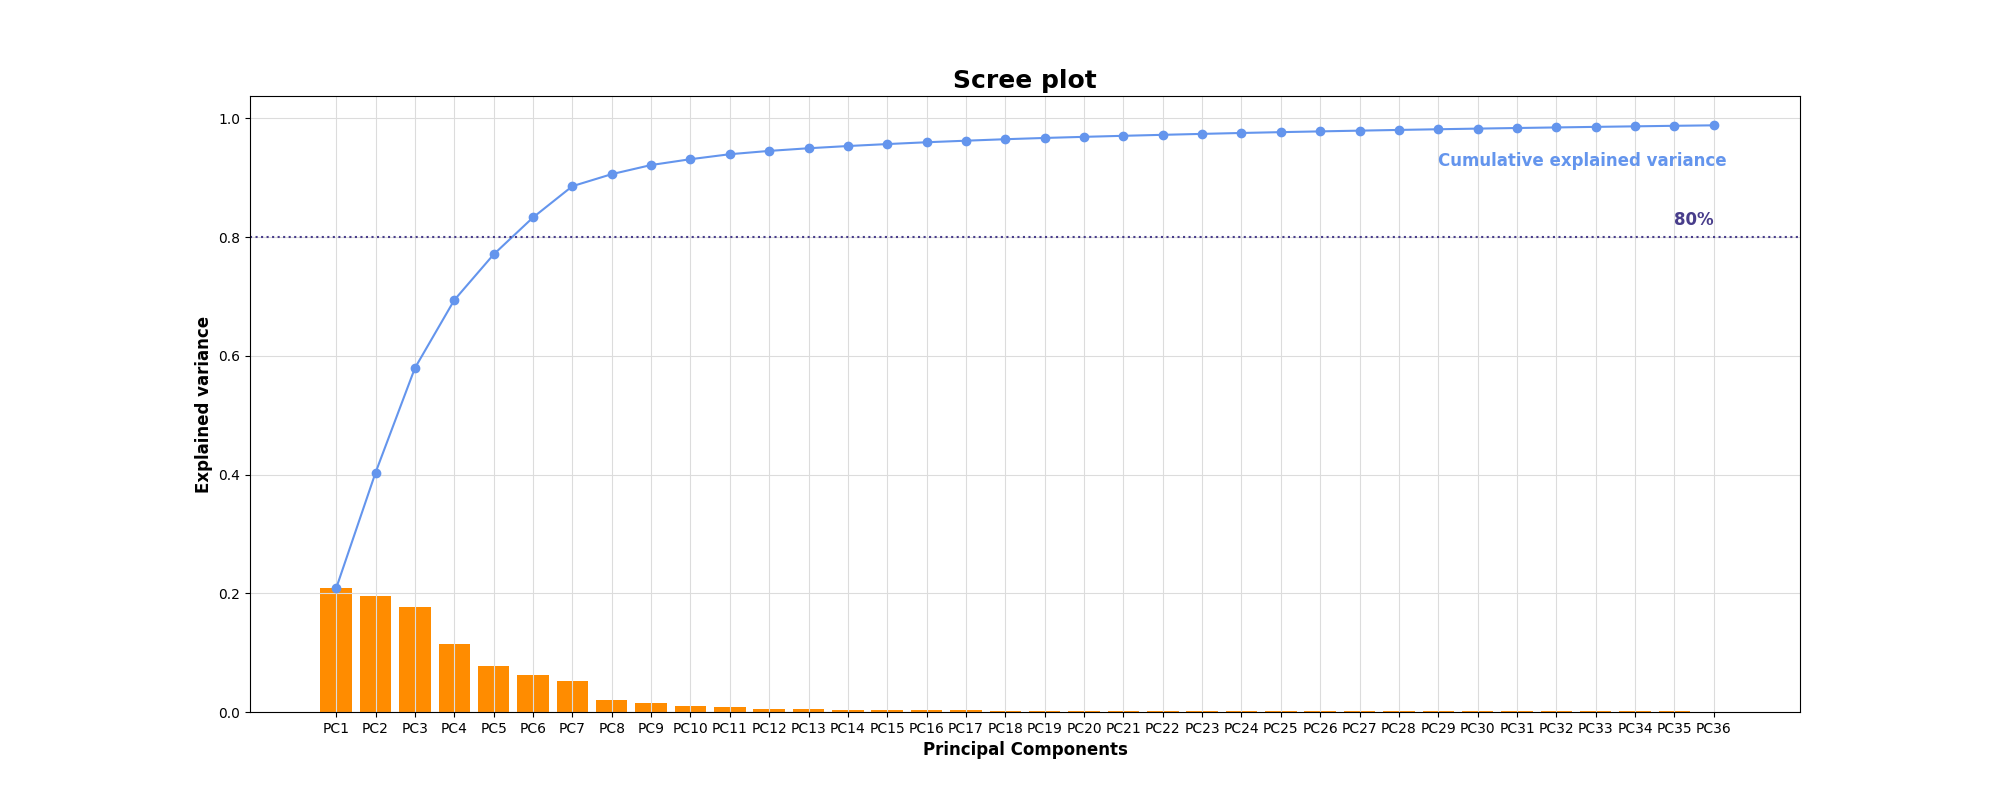

In [31]:
# scree plot - % explained variance

# calculate cumulated explained variance of components
df_var_trim['cum_var'] = df_var['explained_var'].cumsum()

# plot explained variance per component vs. total explained variance
fig, ax = plt.subplots(1, 1, figsize=[25, 15])
plt.figure(figsize=(20,8))
plt.bar(df_var_trim['component'], df_var_trim['explained_var'], color='darkorange')
plt.plot(df_var_trim['component'], df_var_trim['cum_var'], color='cornflowerblue', marker='o')
plt.text(28, 0.92, "Cumulative explained variance", color='cornflowerblue', fontweight='bold', fontsize=12)
plt.xlabel("Principal Components", fontweight='bold', fontsize=12)
plt.xticks(np.arange(0, df_var_trim.shape[0], 1))
plt.ylabel("Explained variance", fontweight='bold', fontsize=12)
plt.text(34, 0.82, "80%", color='darkslateblue', fontweight='bold', fontsize=12)
plt.axhline(y=0.8, color='darkslateblue', linestyle=':')
plt.title("Scree plot", fontweight='bold',fontsize=18)
plt.grid(axis='both', color='gainsboro')
plt.show()
%matplot plt

## 3.3 - Export results to s3

In [32]:
# convert pandas df to Spark df
spark_PCA = sqlContext.createDataFrame(df_var_trim)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
# export ACP results to parquet file
spark_PCA.write.option("encoding", "utf-8").mode("overwrite").parquet(PATH_PCA)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
# check export
df_PCA = pd.read_parquet(PATH_PCA, engine='pyarrow')
df_PCA.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  component  explained_var   cum_var
0       PC1       0.208529  0.208529
1       PC2       0.194787  0.403316
2       PC3       0.176107  0.579423
3       PC4       0.114533  0.693956
4       PC5       0.076908  0.770865

In [37]:
# export ACP results to csv file
# spark_PCA.write.option("encoding", "utf-8").csv(PATH_PCA_CSV, header=True, mode="overwrite")
df_var_trim.to_csv(path_or_buf=PATH_PCA_CSV, header=True, index=False, mode='w', encoding='utf-8')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
# check export
# delim_whitespace=True,
df_PCA_csv = pd.read_csv(PATH_PCA_CSV,  delimiter=',')
df_PCA_csv.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  component  explained_var   cum_var
0       PC1       0.208529  0.208529
1       PC2       0.194787  0.403316
2       PC3       0.176107  0.579423
3       PC4       0.114533  0.693956
4       PC5       0.076908  0.770865

In [39]:
# end of notebook

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…